## QAOA
Given a classical cost function $C(z)$ defined on n-bit strings $z = (z_1, z_2, . . . , z_n) \in \{+1, −1\}^{n}$, the QAOA is a quantum algorithm that aims to find a string $z$ such that $C(z)$ is close to its absolute minimum. The cost function $C$ can be written as an operator that is diagonal in the computational basis, defined as

$$
C|z\rangle = C(z)|z\rangle
$$

The QAOA consists of two components that are repeatedly applied. The first component is parameterized evolution under the diagonal problem
Hamiltonian C,
$$
U_{C}(\gamma) = e^{-i\gamma C}
$$

The second component is parameterized evolution under a local transverse field driver Hamiltonian B,

$$
U_{B}(\beta) = e^{−i\beta B} = \prod_{j=1}^{n}e^{-i\beta X_{j}} \;;\;   B = \sum_{j=1}^{n}X_{j}
$$

The QAOA is a variational algorithm that uses repeated application of these unitaries to prepare a parameterized
state that is then optimized. The depth of the variational algorithm is usually denoted as “p” in the QAOA literature.
Specifically, for depth p we prepare a state parameterized by $\gamma = (\gamma_1, . . . , \gamma_p)$ and $\beta = (\beta_1, . . . , \beta_p)$

$$
|\gamma, \beta\rangle = U_{B}(\beta_p) U_{C}(\gamma_p) ... U_{B}(\beta_1) U_{C}(\gamma_1) |+\rangle^{\otimes n}
$$

For a given p, we attempt to find parameters that minimize the expectation value of the cost
$$
\langle C \rangle = \langle \gamma, \beta | C | \gamma, \beta \rangle
$$

## SK Model

The Sherrington-Kirkpatrick (SK) model describes a classical spin system with all-to-all couplings between the $n$ spins. The classical cost function $C$ is defined as:
$$
C(z) = \sum_{j < k}^{n} w_{j, k} z_{j} z_{k} \; \text{where}\;  w_{j, k} \in \{+1, -1\}
$$

By adding a global phase factor, we can shift the values of the weights s.t. $w_{j, k} \in \{0, 1\}$
## Analyzing costs of Phase Oracles $U_{C}(\gamma)$ for FT Resource Estimation
The phase oracle $O^{\text{phase}}(\gamma)$ is defined as 
$$
    O^{\text{phase}}(\gamma) |z\rangle = e^{-i \gamma C(z)} |z\rangle
$$

In the notebook below, we will see three different ways to implement the unitary $U_{C}(\gamma)$ that synthesizes the phase oracle and analyze fault tolerant costs for each of these. 

## SKPhaseOracleNaiveRZZ

Since the $Z_{j}Z_{k}$ operators all commute with each other, a straightforward implementation of the phase oracle would be to write $U_{C}(\gamma)$ as follows:

$$
U_{C}(\gamma) = e^{-i\gamma C} = \prod_{j < k}^{n}e^{-i \gamma w_{j, k} Z_{j} Z_{k}}
$$

Thus, we can decompose $U_{C}(\gamma)$ into $\frac{n(n-1)}{2}$ 2-qubit operations. Each of the 2-qubit unitaries can be implemented in `Qualtran` as an `ZZPowGate` gate as follows:

```python
    def rzz(gamma):
        return ZZPowGate(exponent=2 * gamma / np.pi, global_shift=-0.5)
```

The naive phase oracle for the SK model can be constructed using Qualtran via `SKPhaseOracleNaiveRZZ`

In [ ]:
import sympy
import numpy as np
from qualtran.drawing import show_call_graph, show_counts_sigma

from qualtran.bloqs.qaoa.sk_model_phase_oracle import SKPhaseOracleNaiveRZZ, SKPhaseViaCostQvrZPow, SKPhaseViaCostQvrPhaseGrad
from qualtran.resource_counting.t_counts_from_sigma import t_counts_from_sigma


n, gamma, eps = sympy.symbols('n, \gamma, \epsilon')

def get_weights(n):
    # if isinstance(n, sympy.Expr):
    return sympy.Symbol('weights')
    rng = np.random.default_rng(12345)
    return tuple((-1) ** rng.integers(low=0, high=1, size=(n * (n - 1)) // 2, endpoint=True)) # nC2 weights for the cost function.



sk_phase_oracle_naive_rzz = SKPhaseOracleNaiveRZZ(n, gamma, get_weights(n), eps)
sk_phase_oracle_naive_rzz_g, sk_phase_oracle_naive_rzz_sigma = sk_phase_oracle_naive_rzz.call_graph()
show_call_graph(sk_phase_oracle_naive_rzz_g)
show_counts_sigma(sk_phase_oracle_naive_rzz_sigma)

def get_sk_phase_oracle_naive_rzz_bloq(n, gamma, eps):
    return SKPhaseOracleNaiveRZZ(n, gamma, get_weights(n), eps)

def get_sk_phase_oracle_naive_rzz_t_counts(n, gamma, eps):
    bloq = get_sk_phase_oracle_naive_rzz_bloq(n, gamma, eps)
    _, sigma = bloq.call_graph()
    return t_counts_from_sigma(sigma)

get_sk_phase_oracle_naive_rzz_t_counts(n, gamma, eps)

## Optimized Phase Oracles for FT Resource Estimation

In the naive implementation shown above, the phase oracle $O^{\text{phase}}(\gamma)$ is implemented simply as the unitary $U_{C}(\gamma)$ defined as
$$
U_{C}(\gamma) = e^{-i\gamma C} = \prod_{j < k}^{n}e^{-i \gamma w_{j, k} Z_{j} Z_{k}}
$$


However, in the Fault Tolerant setting, we aim to come up with optimized implementations of $O^{\text{phase}}(\gamma)$ that reduce the Toffoli count. One trick we can use is to compute the cost $C(z)$ for each bitstring $|z\rangle$ in a separate register and then apply a quantum variable rotation (QVR) to phase each state $|z\rangle |c(z)\rangle$ with a value proportional $\gamma * C(z)$. This trick can be implemented using the `PhasingViaCostFunction` Bloq in Qualtran which expects a cost function evaluation oracle and a QVR oracle. 


### Cost Function Evaluation Oracle
Let $O^{\text{direct}}$ represent an oracle that evaluates the cost function $C(z)$ and stores the output in a new clean register. 

$$
    O^{\text{direct}}|z\rangle |0\rangle^{\otimes b_{\text{dir}}}  = |z\rangle |c(z)\rangle
$$

Here $b_{\text{dir}}$ is the bitsize of the newly allocated ancilla register. For SK model, it is equal to $b_\text{dir}=2\log{N}$ and Toffoli cost scales as $\mathcal{O}(N^2)$. We will use the `SKModelCostEval` bloq to evaluate the cost of a given SK model instance in a new cost register.

### QVR Oracles
Qualtran has two different ways to implement the QVR primitive - `QvrPhaseGradient` and `QvrZPow`.  We will use these two oracles to analyze the costs for implementing the phase oracles oracle for SK model. 


## SKPhaseViaCostQvrZPow
This Bloq uses the phasing via cost function approach described above with `QvrZPow` bloq to implement the QVR. 

In [ ]:
sk_phase_via_cost_qvr_zpow = SKPhaseViaCostQvrZPow(n, gamma, get_weights(n), eps)
sk_phase_via_cost_qvr_zpow_g, sk_phase_via_cost_qvr_zpow_sigma = sk_phase_via_cost_qvr_zpow.call_graph()
show_call_graph(sk_phase_via_cost_qvr_zpow_g)
show_counts_sigma(sk_phase_via_cost_qvr_zpow_sigma)

def get_sk_phase_via_cost_qvr_zpow_bloq(n, gamma, eps):
    return SKPhaseViaCostQvrZPow(n, gamma, get_weights(n), eps)
    
def get_sk_phase_via_cost_qvr_zpow_t_counts(n, gamma, eps):
    bloq = get_sk_phase_via_cost_qvr_zpow_bloq(n, gamma, eps)
    _, sigma = bloq.call_graph()
    return t_counts_from_sigma(sigma)

get_sk_phase_via_cost_qvr_zpow_t_counts(n, gamma, eps)

In [ ]:
sk_phase_via_cost_qvr_phase_grad = SKPhaseViaCostQvrPhaseGrad(n, gamma, get_weights(n), eps)
sk_phase_via_cost_qvr_phase_grad_g, sk_phase_via_cost_qvr_phase_grad_sigma = sk_phase_via_cost_qvr_phase_grad.call_graph()
show_call_graph(sk_phase_via_cost_qvr_phase_grad_g)
show_counts_sigma(sk_phase_via_cost_qvr_phase_grad_sigma)

def get_sk_phase_via_cost_qvr_phase_grad_bloq(n, gamma, eps):
    return SKPhaseViaCostQvrPhaseGrad(n, gamma, get_weights(n), eps)
    
def get_sk_phase_via_cost_qvr_phase_grad_t_counts(n, gamma, eps):
    bloq = get_sk_phase_via_cost_qvr_phase_grad_bloq(n, gamma, eps)
    _, sigma = bloq.call_graph()
    return t_counts_from_sigma(sigma)

get_sk_phase_via_cost_qvr_phase_grad_t_counts(n, gamma, eps)

In [ ]:
import matplotlib.pyplot as plt

gamma = 0.1

n_vals = np.logspace(2, 12, 10, base=2, dtype=int).tolist()
for eps_pow in [-1, -3, -5]:
    eps = 10**eps_pow
    cost_naive = [get_sk_phase_oracle_naive_rzz_t_counts(n, gamma, eps) for n in n_vals]
    cost_zpow = [get_sk_phase_via_cost_qvr_zpow_t_counts(n, gamma, eps) for n in n_vals]
    cost_qvr = [get_sk_phase_via_cost_qvr_phase_grad_t_counts(n, gamma, eps) for n in n_vals]
    plt.plot(n_vals, cost_naive, label=f'naive; $\epsilon=10^{{{eps_pow}}}$')
    plt.plot(n_vals, cost_zpow, label=f'zpow; $\epsilon=10^{{{eps_pow}}}$')
    plt.plot(n_vals, cost_qvr, label=f'qvr; $\epsilon=10^{{{eps_pow}}}$')

plt.xlabel("n")
plt.ylabel("SK Model QAOA Step: TCount($n$)")
plt.legend()
plt.show()    

In [ ]:
import matplotlib.pyplot as plt

gamma_best, gamma_worst = 0.5, (2**20-1)/2**20
print(gamma_best, gamma_worst)
gamma=0.1
plt.figure(figsize=(16, 8))

n_vals = np.logspace(2, 12, 10, base=2, dtype=int).tolist()
for eps_pow in [-1, -2, -3, -4, -5]:
    eps = 10**eps_pow
    cost_zpow = [get_sk_phase_via_cost_qvr_zpow_t_counts(n, gamma, eps) - 4*n**2 for n in n_vals]
    cost_qvr_best = [get_sk_phase_via_cost_qvr_phase_grad_t_counts(n, gamma_best, eps) - 4*n**2 for n in n_vals]
    cost_qvr_worst = [get_sk_phase_via_cost_qvr_phase_grad_t_counts(n, gamma_worst, eps) - 4*n**2 for n in n_vals]
    plt.plot(n_vals, cost_zpow, label=f'zpow; $\epsilon=10^{{{eps_pow}}}$', linestyle=':')
    plt.plot(n_vals, cost_qvr_best, label=f'qvr; $\epsilon=10^{{{eps_pow}}}$, $\gamma$=0.1')
    plt.plot(n_vals, cost_qvr_worst, label=f'qvr; $\epsilon=10^{{{eps_pow}}}$; $\gamma$=0.11111...', linestyle='--')

plt.xlabel("n")
plt.ylabel("SK Model QAOA Step: TCount($n$) - $4 n^2$")
plt.xscale('log', base=2)
plt.legend()
plt.show()    

## Appendix: Costs from [Compilation of Fault-Tolerant Quantum Heuristics for Combinatorial Optimization](https://arxiv.org/abs/2007.07391)

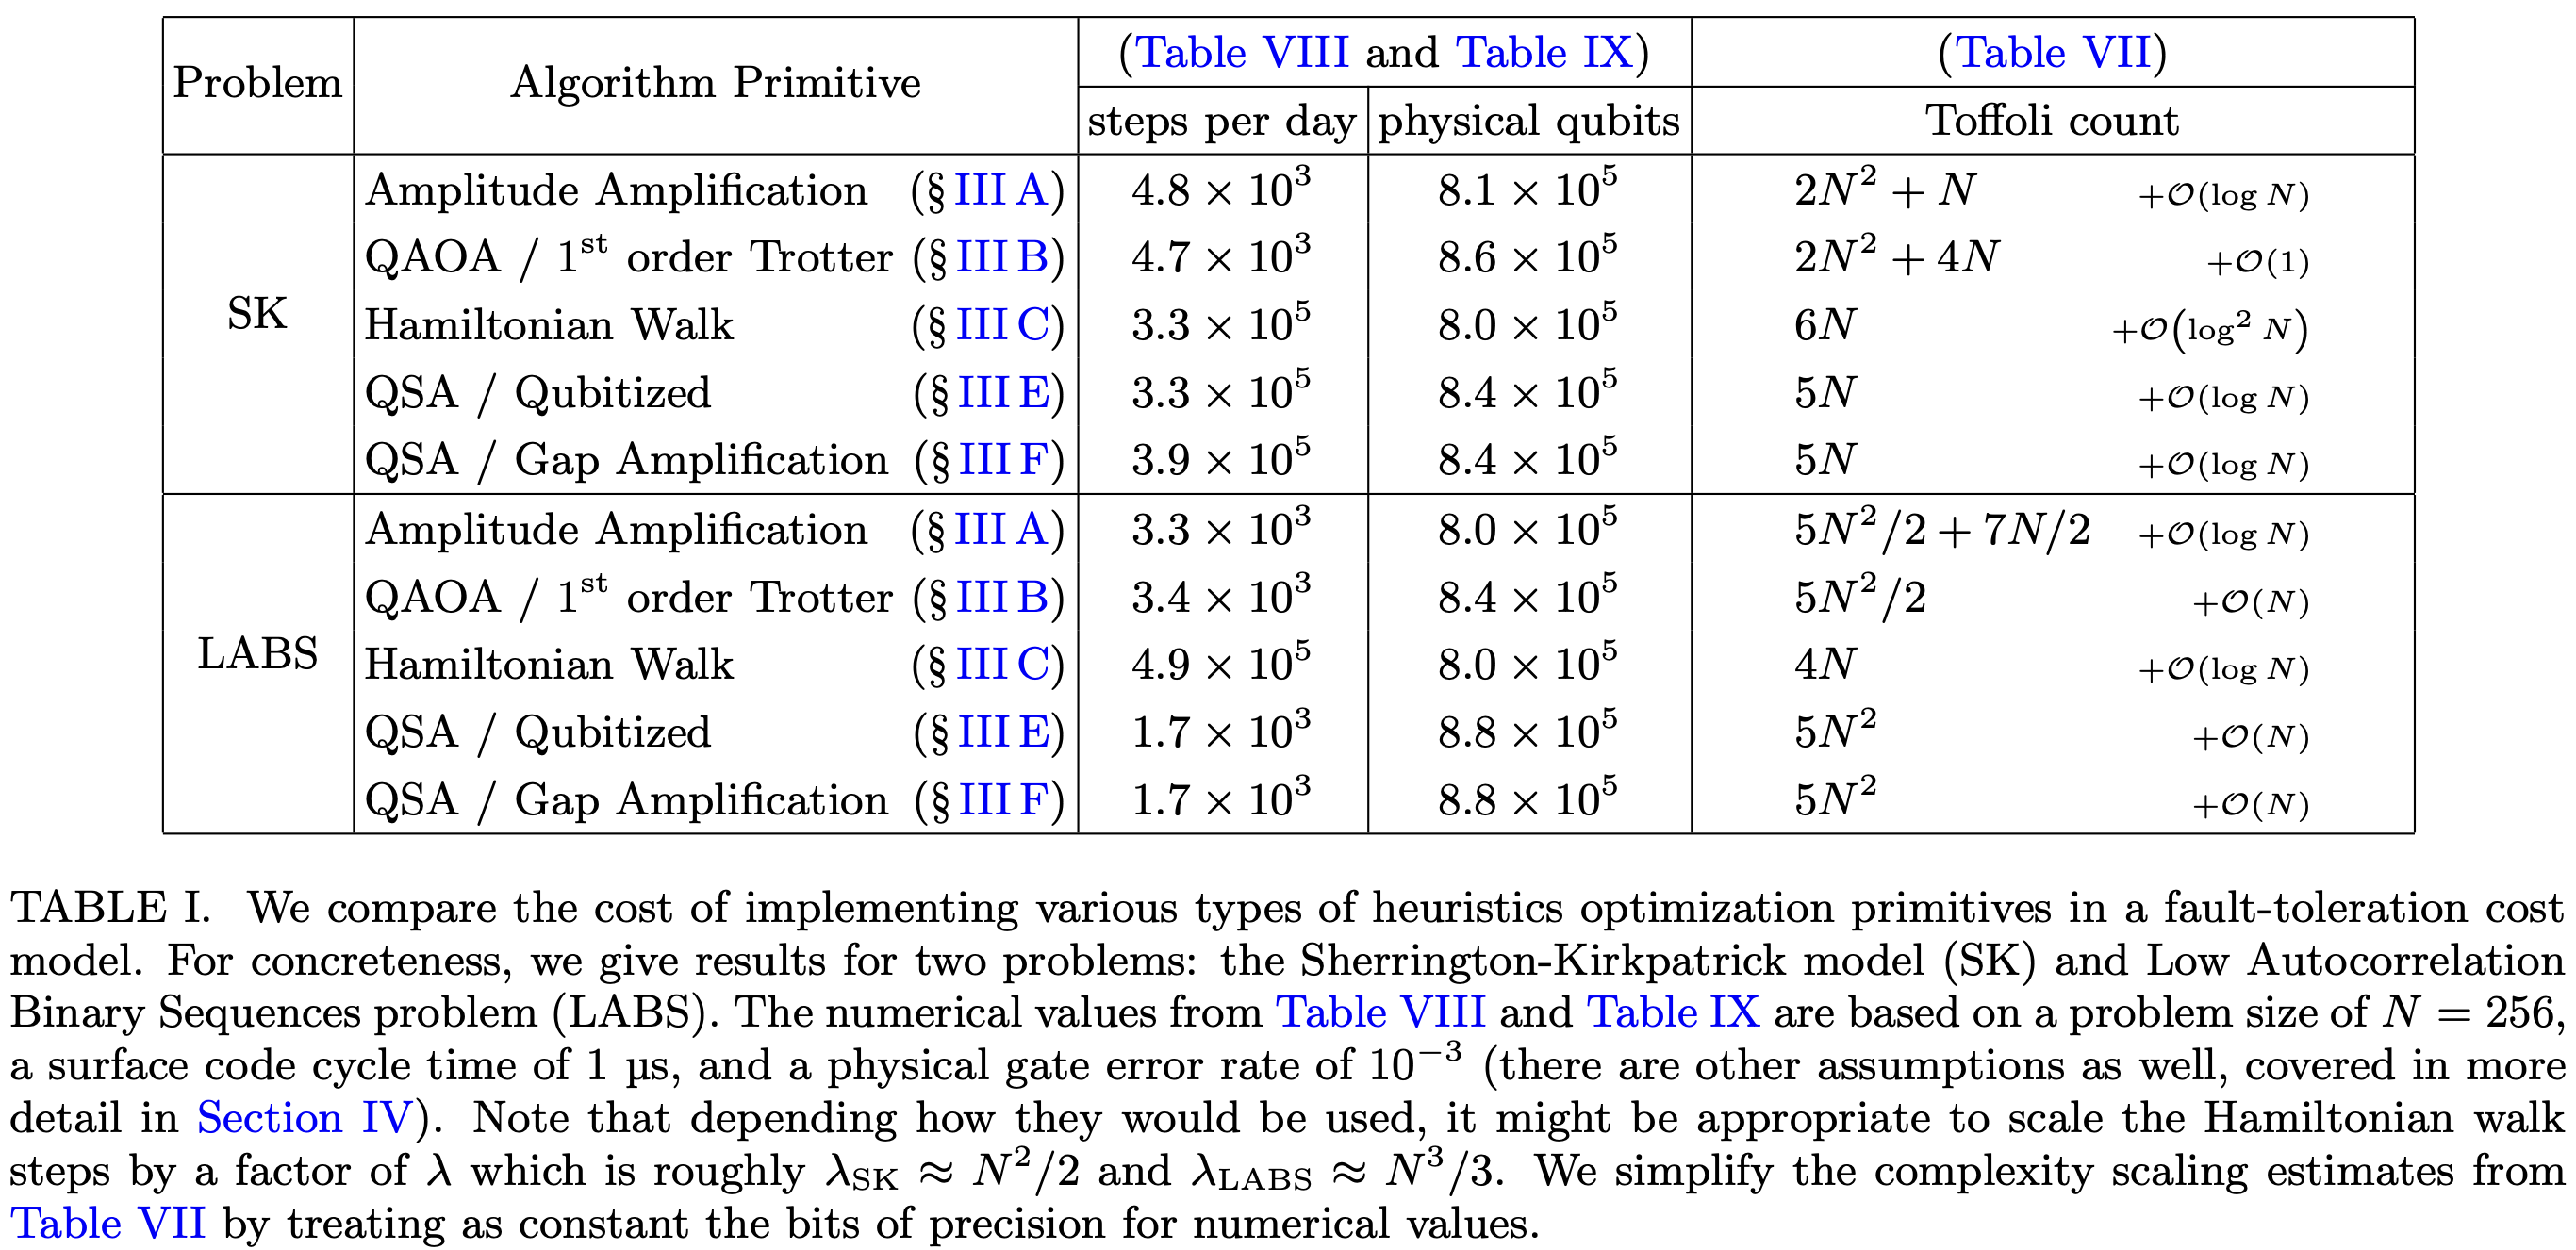

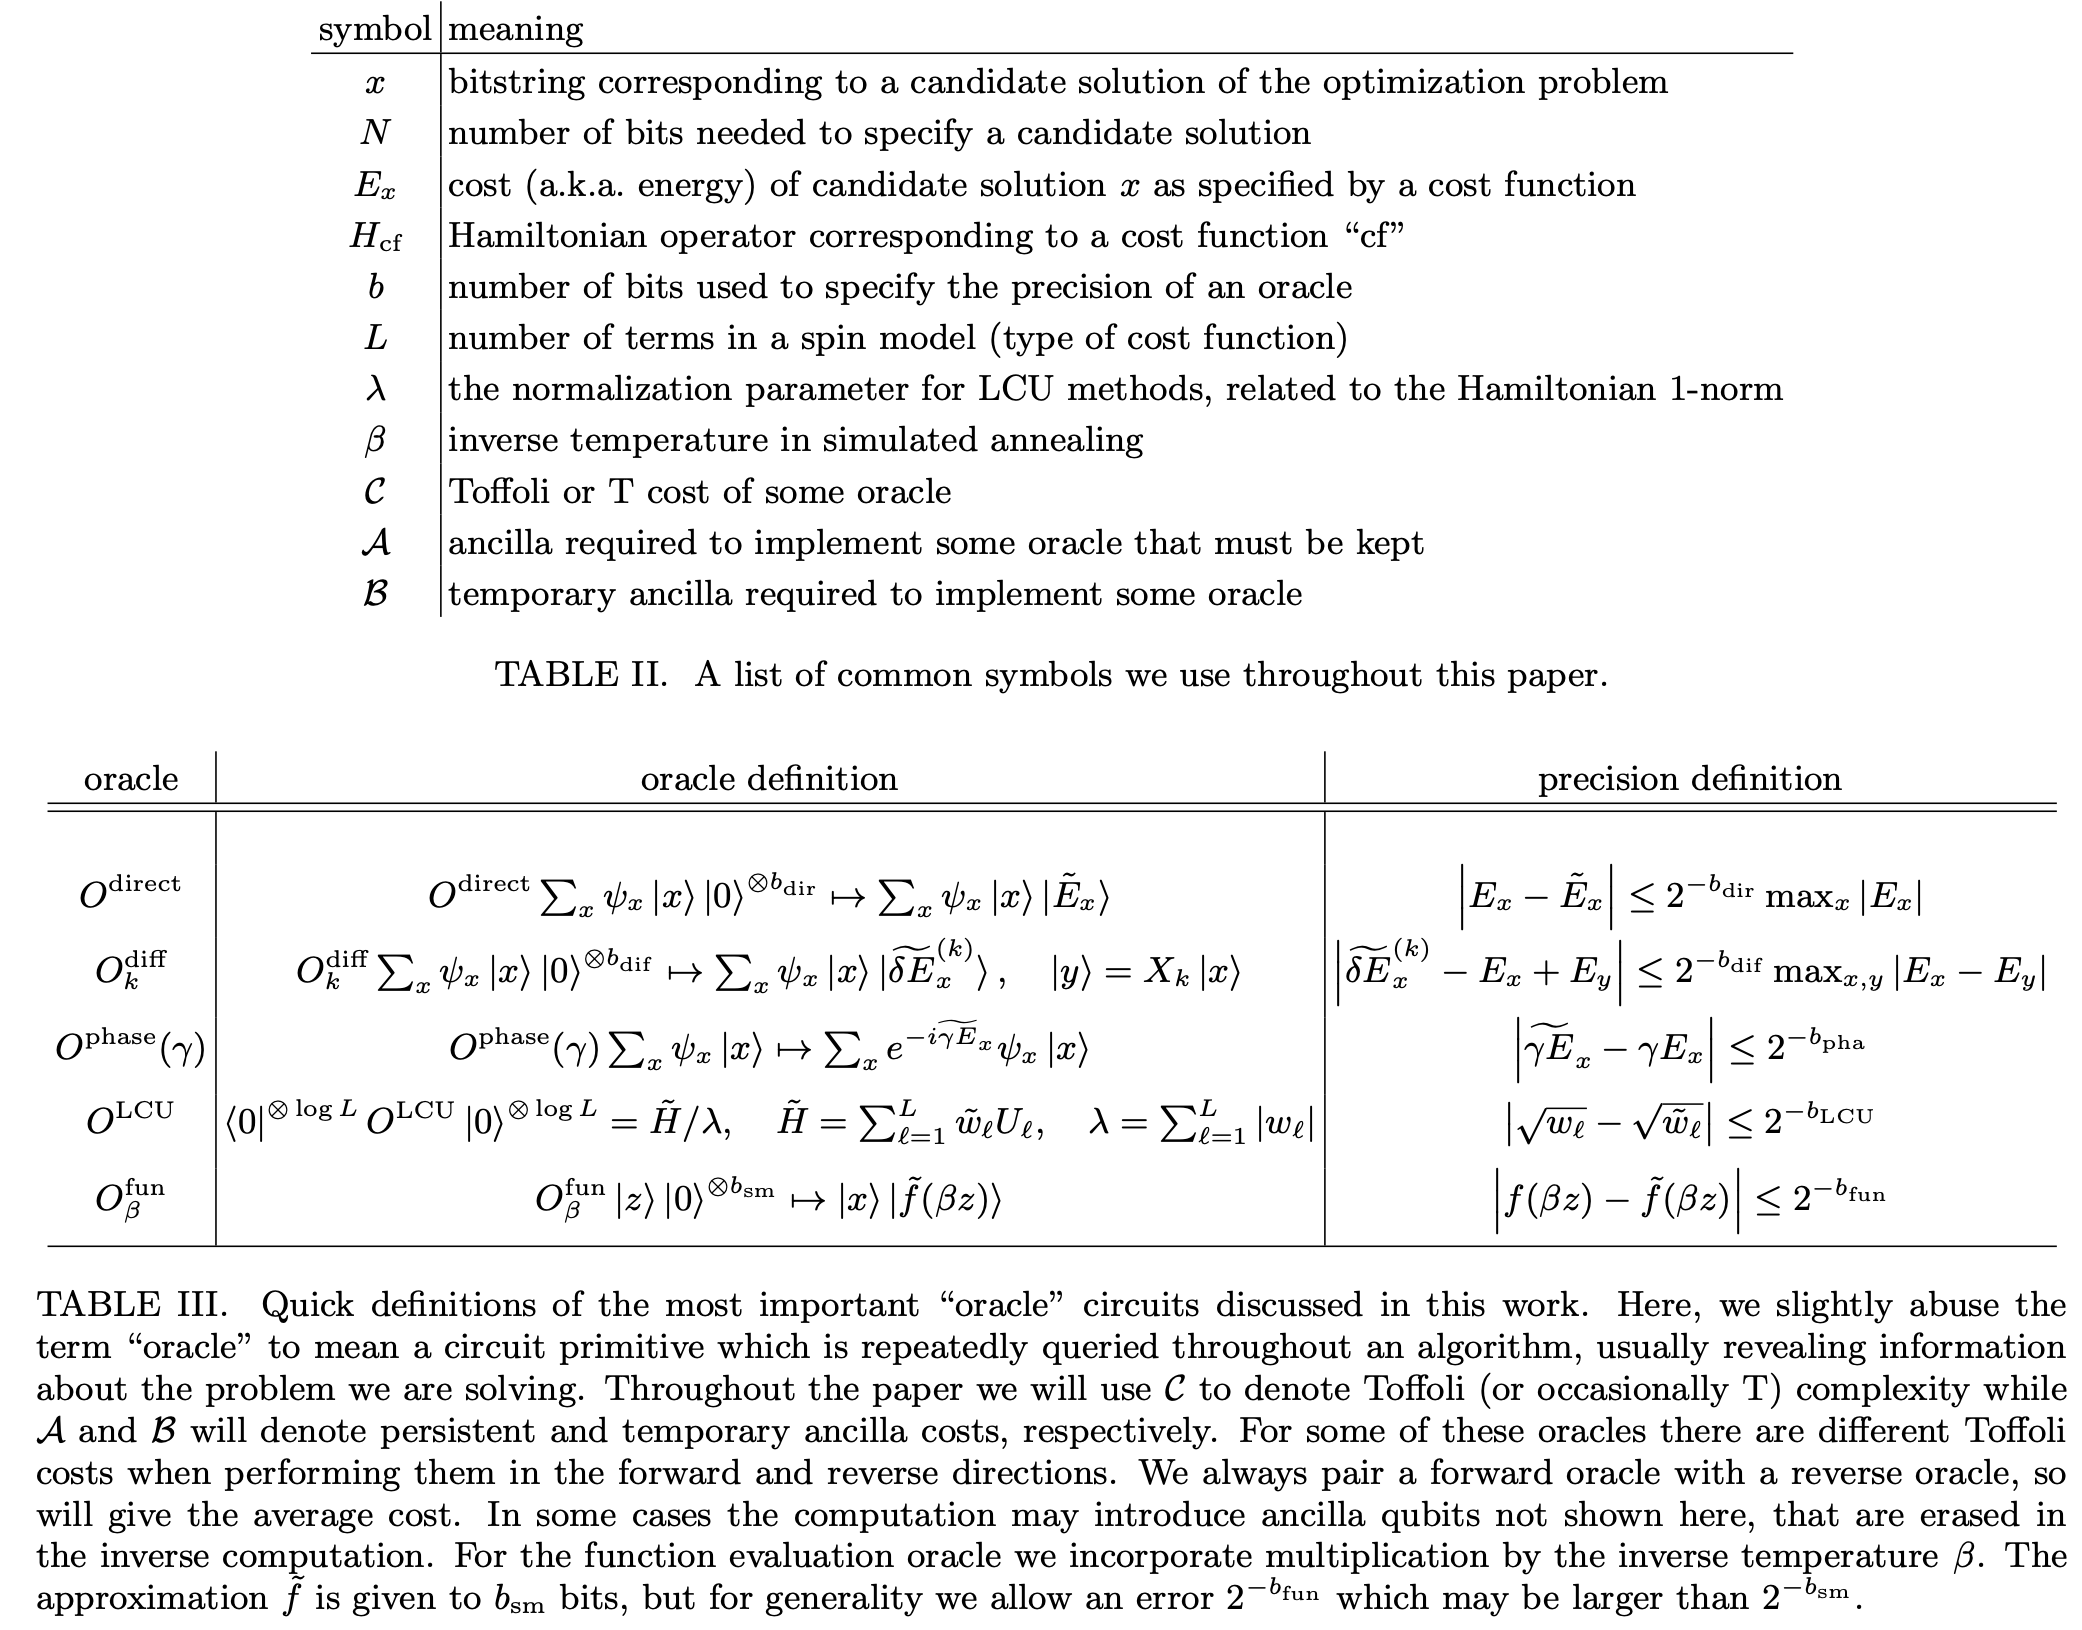

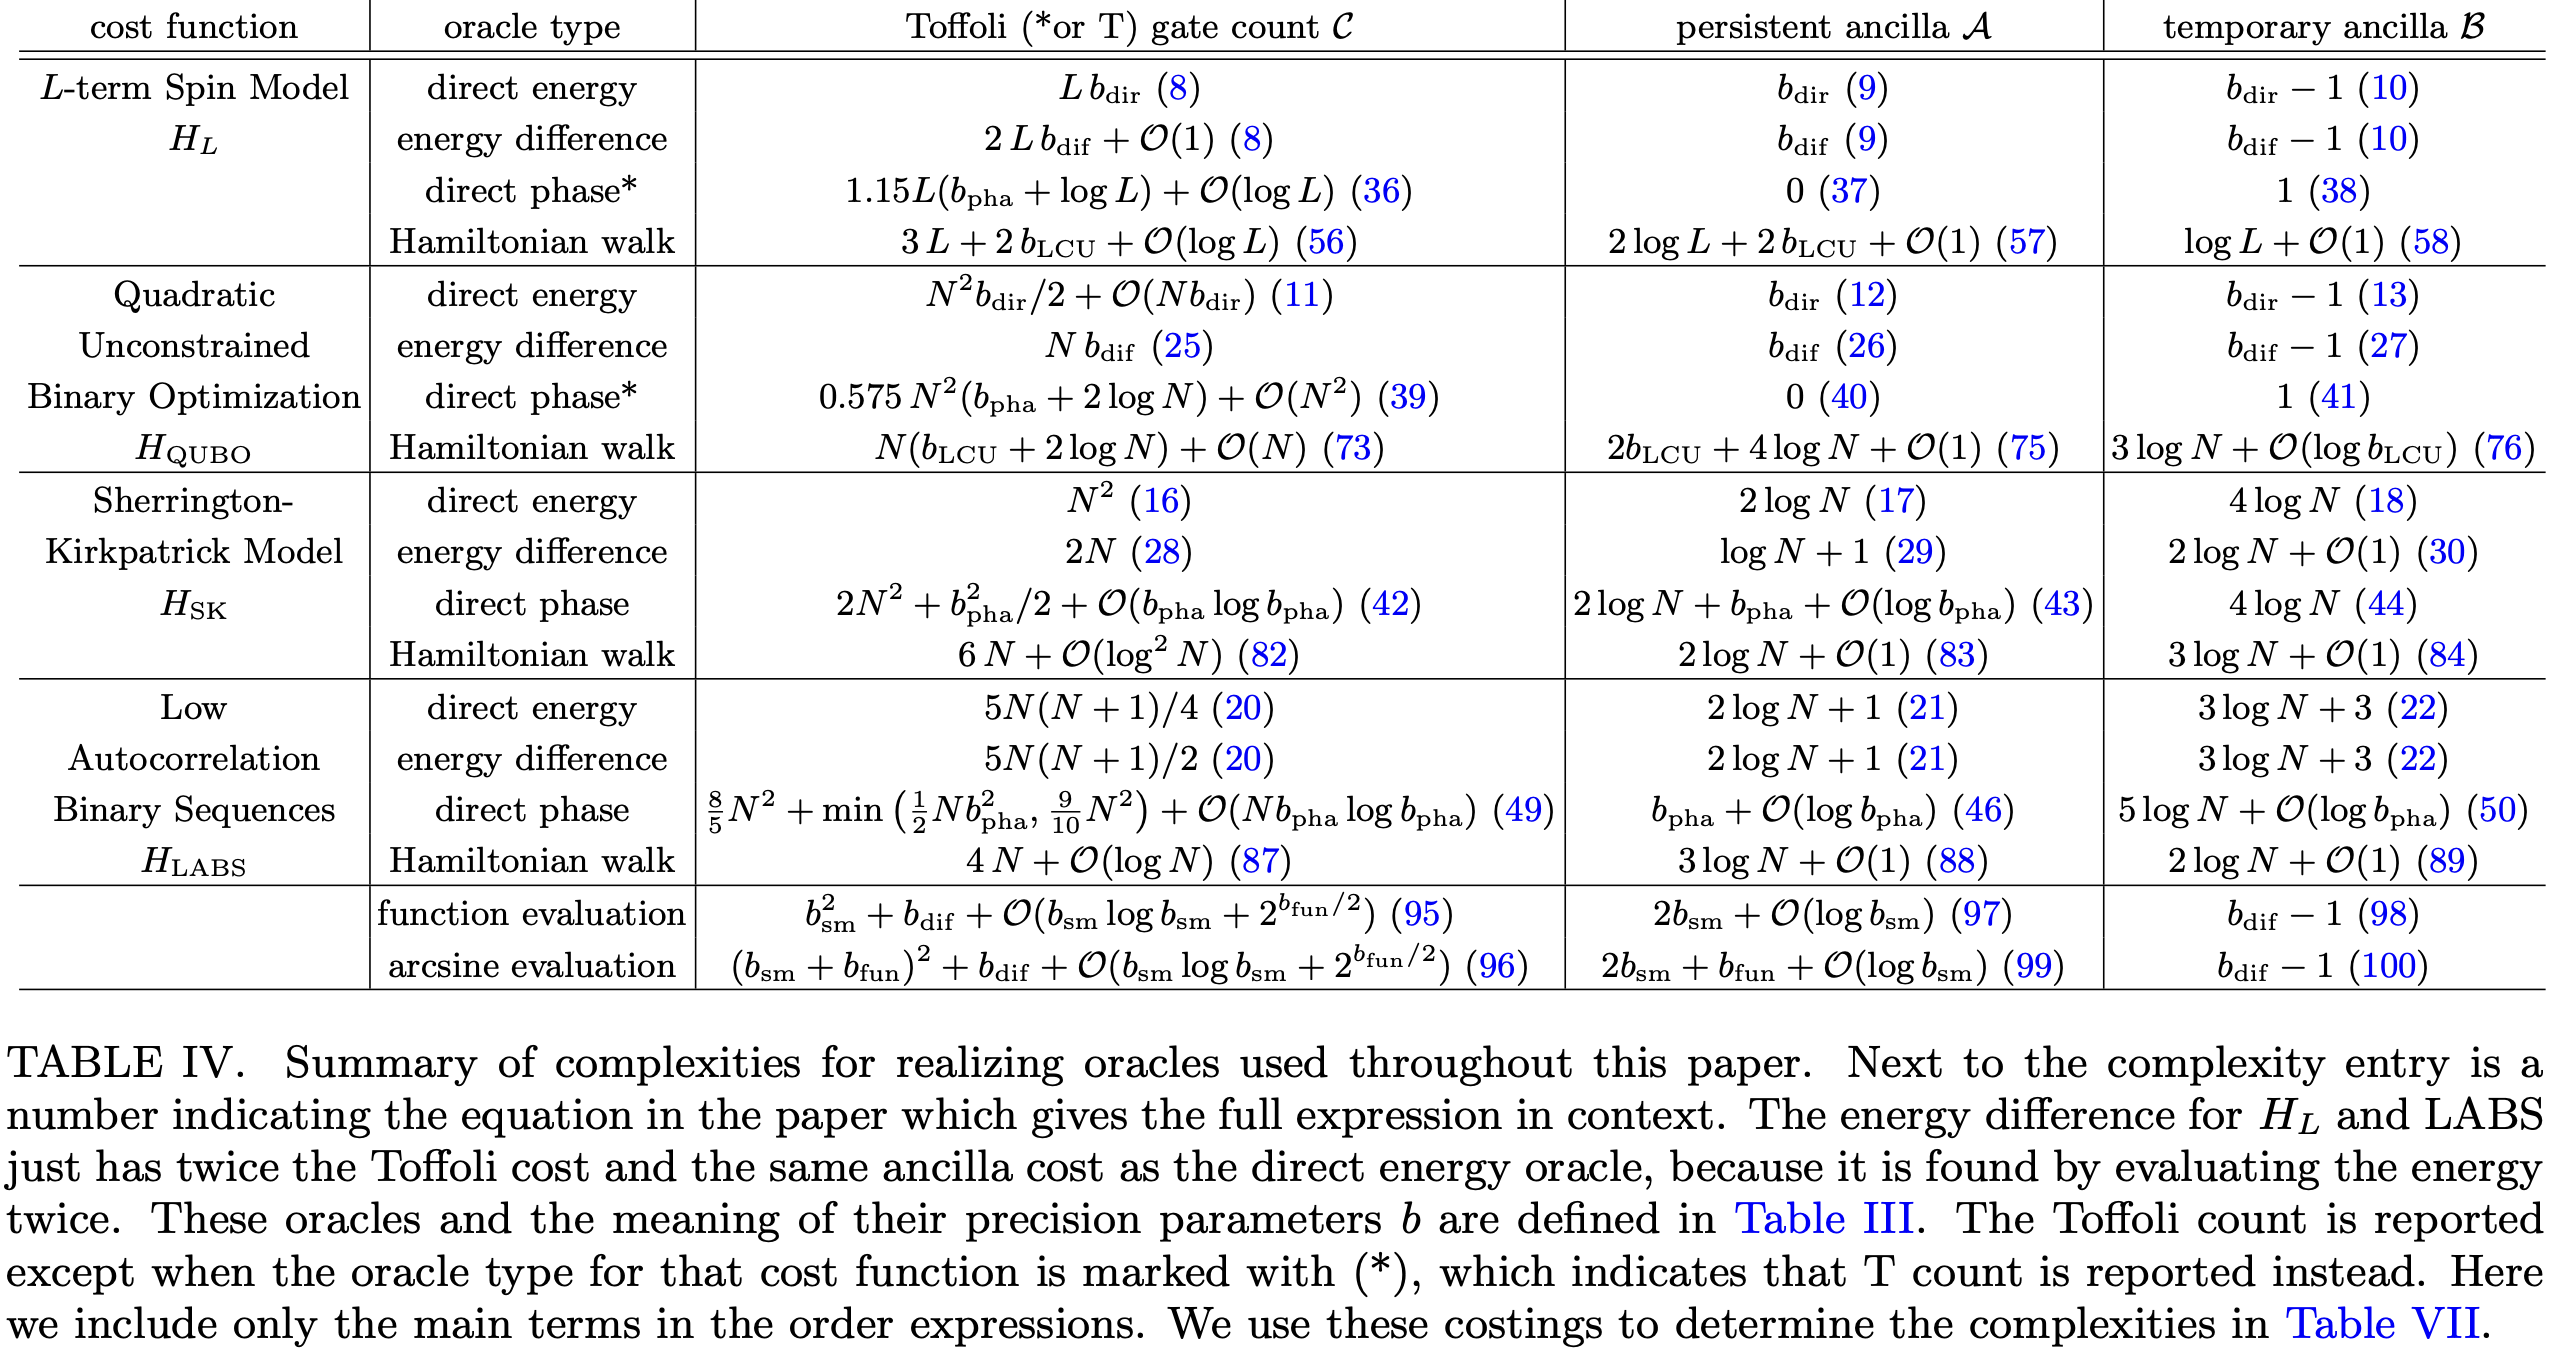

